<a href="https://colab.research.google.com/github/TheMrGhostman/NeuroEvolution_for_simple_games/blob/master/RandomShooting_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import random
from copy import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import gym

## Most of th code is refactored from Neuroevolution

In [0]:
class Net(nn.Module):
    def __init__(self, in_,  out_, activation=nn.Tanh()):
        super(Net, self).__init__()
        self.in_ = in_
        self.out_ = out_
        self.module_list = [in_, 160,160,160, out_]
        self.model = self.setup_model(activation)
        self.n_weights = self.sum_parameters(self.model)

    @staticmethod
    def sum_parameters(model):
        def prod(array):
            array = np.array(array)
            return array.prod()
        n_params = 0
        for param in model.parameters():
            n_params += prod(param.shape)
        return n_params
    
    def setup_model(self, activation):
        od = {}
        for i in range(len(self.module_list)-1):
            od[f"layer_{i}"] = nn.Linear(self.module_list[i], self.module_list[i+1], bias=False)
            if i!=len(self.module_list)-2:
                od[f"activation_{i}"] = activation
        model = nn.Sequential(OrderedDict(od))
        for params in model.parameters():
            params.requires_grad=False
        return model

    def forward(self, x, out_activation="softmax"):
        return self.model(x)

In [0]:
class Agent(object):
    def __init__(self, state_space, action_space):
        self.state_space = state_space
        self.action_space = action_space
        self.brain = Net(in_=state_space, out_=action_space)
        self.n_genes = self.brain.n_weights
        # agents memory
        self.reached_score = 0
        self.new_state = None
        self.done = False


    def act(self, state):
        predicted_action = torch.sigmoid(self.brain(state))
        return predicted_action
    
    def act_from_memory(self, argmax=False):
        if argmax:
            return torch.argmax(self.brain(torch.tensor(self.new_state).float()))
        else:
            return torch.sigmoid(self.brain(torch.tensor(self.new_state).float()))

    def update_agent(self, NsRD_):
        self.new_state = NsRD_[0]
        self.reached_score += NsRD_[1]
        self.done = NsRD_[2]

    def get_gene(self):
        def prod(array):
            array = np.array(array)
            return array.prod()
        gene = []
        config_size = []
        config_idx = []
        for param in self.brain.parameters():
            pr = int(self.prod(param.shape))
            config_size.append(param.shape)
            config_idx.append(pr)
            gene.append(param.view(pr))
        config_idx = np.cumsum(config_idx)
        config = [(size, idx) for size, idx in zip(config_size, config_idx)]
        gene = torch.cat(gene)
        return gene, config

    def set_gene(self, gene, config):
        config.insert(0, (0, 0))
        for i, param in enumerate(self.brain.parameters()):
            param = gene[config[i][1]:config[i+1][1]].view(config[i+1][0])
        return self


In [0]:
class Population(object):
    def __init__(self, n_agents, state_space, action_space):
        """
        m_agents should be divisible with 2 without remainder 
        """
        self.n_agents = n_agents
        self.state_space = state_space
        self.action_space = action_space
        self.population = self.create_population(n_agents, state_space, action_space)
        self.scores_per_generation = {"min":[], "max":[], "score":[], "mean":[], "std":[]}

    @staticmethod
    def create_population(n_agents, state_space, action_space):
        pop = []
        for i in range(n_agents):
            pop.append(Agent(state_space=state_space, action_space=action_space))
        return pop

    def evaluation_loop(self, envs, n_generations, repeats=3, use_argmax=True, replace=False):
        for generation in tqdm(range(n_generations)):
            scores = []
            # reset
            for i in range(repeats):
                for agent, env in zip(self.population, envs):
                    # reset enviroment
                    agent.new_state = env.reset()
                    # reset reached score
                    agent.reached_score = 0
                    agent.done=False
                
                # evaluation fitness function
                for s in range(500):
                    for agent, env in zip(self.population, envs):
                        if agent.done:
                            continue
                        else:
                            # argmax
                            act = np.array(agent.act_from_memory(argmax=use_argmax))
                            agent.update_agent(env.step(act))
                # appending score
                scores.append(np.array([agent.reached_score for agent in self.population]))

            # complete evaluation in generation
            scores = np.vstack(scores).mean(axis=0) # mean score of through repeats
            # loging results
            self.scores_per_generation["min"].append(np.min(scores))
            self.scores_per_generation["max"].append(np.max(scores))
            self.scores_per_generation["score"].append(scores)
            self.scores_per_generation["mean"].append(np.mean(scores))
            self.scores_per_generation["std"].append(np.std(scores))
                
            # i want to return last evaluated generation
            if generation==n_generations-1:
                break
            else:
                self.population = self.create_population(self.n_agents, self.state_space, self.action_space)
        return self

# Evaluation loop

In [0]:
POPULATION = 2000
GENERATIONS = 10
REPEATS=3

In [0]:
multi_enviroment = [gym.make("CartPole-v1") for i in range(POPULATION)]

STATE_SPACE = multi_enviroment[0].observation_space.shape[0]
ACTION_SPACE = multi_enviroment[0].action_space.n

In [0]:
pop = Population(POPULATION, STATE_SPACE, ACTION_SPACE)

In [18]:
pop.evaluation_loop(
    envs=multi_enviroment, 
    n_generations=GENERATIONS,  
    repeats=REPEATS, 
    use_argmax=True, 
    replace=False)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:51<16:44, 111.65s/it]

 20%|██        | 2/10 [03:37<14:39, 109.89s/it]

 30%|███       | 3/10 [05:23<12:40, 108.68s/it]

 40%|████      | 4/10 [07:06<10:41, 106.96s/it]

 50%|█████     | 5/10 [09:00<09:05, 109.11s/it]

 60%|██████    | 6/10 [10:51<07:19, 109.81s/it]

 70%|███████   | 7/10 [12:46<05:33, 111.27s/it]

 80%|████████  | 8/10 [14:34<03:40, 110.21s/it]

 90%|█████████ | 9/10 [16:25<01:50, 110.40s/it]

In [0]:
score_all = np.hstack(pop.scores_per_generation["score"])

# Statistics

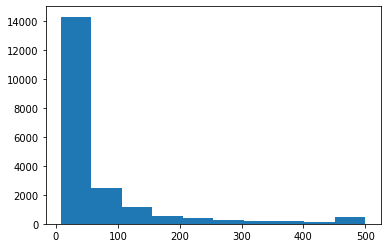

In [33]:
plt.figure()
plt.hist(score_all)
plt.show()

<BarContainer object of 10 artists>

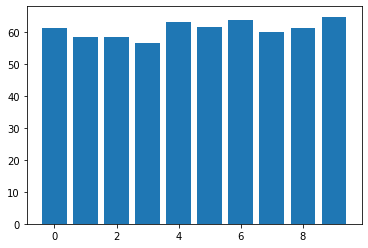

In [51]:
plt.bar(np.arange(10), np.mean(pop.scores_per_generation["score"], axis=1))

In [75]:
rel_tot = np.argwhere(score_all >300).squeeze().shape[0]/score_all.shape[0] #reliability total
rel_tot

0.04545

In [70]:
rel_per_gen = np.array([np.argwhere(np.argwhere(np.array(pop.scores_per_generation["score"])>300)[:,0]==i).shape[0] for i in range(0,10)])/pop.n_agents
rel_per_gen

array([0.047 , 0.038 , 0.0415, 0.0415, 0.0525, 0.048 , 0.051 , 0.04  ,
       0.0455, 0.0495])

<BarContainer object of 10 artists>

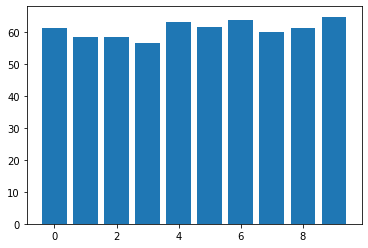

In [44]:
plt.bar(np.arange(10), pop.scores_per_generation["mean"])

In [72]:
mne_tot = np.mean(score_all[score_all>300]) # Mean Number of objective function Evaluations
mne_tot

429.1903190319032

In [96]:
mne_per_gen = np.array([np.mean(np.array(pop.scores_per_generation["score"])[i, np.array(pop.scores_per_generation["score"])[i,:]>300]) for i in range(0,10)])
mne_per_gen

array([434.9964539 , 432.46929825, 430.17269076, 434.25702811,
       423.95238095, 415.97916667, 423.5       , 433.17083333,
       431.17216117, 435.27946128])

In [97]:
feo_tot = mne_tot/rel_tot# Feoktistov criterion: $FEO = MNE/REL$
feo_tot

9443.131331835055

In [98]:
feo_per_gen = mne_per_gen/rel_per_gen# Feoktistov criterion: $FEO = MNE/REL$
feo_per_gen

array([ 9255.24370002, 11380.77100646, 10365.60700634, 10464.02477379,
        8075.28344671,  8666.23263889,  8303.92156863, 10829.27083333,
        9476.31123455,  8793.52447029])

In [100]:
df= pd.DataFrame({"rel_per_gen":rel_per_gen, "mne_per_gen":mne_per_gen, "feo_per_gen":feo_per_gen})
df

,rel_per_gen,mne_per_gen,feo_per_gen
0,0.0470,434.996454,9255.243700
1,0.0380,432.469298,11380.771006
2,0.0415,430.172691,10365.607006
3,0.0415,434.257028,10464.024774
4,0.0525,423.952381,8075.283447
5,0.0480,415.979167,8666.232639
6,0.0510,423.500000,8303.921569
7,0.0400,433.170833,10829.270833
8,0.0455,431.172161,9476.311235
9,0.0495,435.279461,8793.524470
